# Market-implied stock price PDFs

Option prices embed information about the markets expectation of future performance of the underlying asset.
The set of European option prices across strikes for a given maturity $T$ implies a risk-neutral probability density function (details below) of the price $S_T$ of the underlying asset at the maturity.

This density reflects the distribution consistent with current option prices under the pricing measure that discounts payoffs at the risk-free rate.
It also reflects both how the market expects the underlying to move (although it is important to note that the pdf we obtain is NOT simply the market's prediction of where the stock is likely to move), as well as how the market prices risk across the various outcomes.

This project uses several years of daily SPX option chain data to extract the market-implied risk-neutral pdfs for options with 1 day maturities, 7 day maturities, and 28 day maturities.
Using the Breeden-Litzenberger relation, which says that the implied pdf is given by the second partial derivative of price at maturity with respect to strike:
$$ f_Q(K) = e^{rT} \frac{\partial^2 C(K, T)}{\partial K^2},$$
we numerically recover the pdf.
Since strikes come in discrete increments, techniques to interpolate in a suitable way are discussed.

We then discuss and compare ways of recovering the real-world probability distribution from the risk-neutral one.

There are two main goals of this project, and two secondary goals.
The main goals are
1. Compare the risk-neutral pdf to the realized price distribution.
2. Explore ways of estimating the real-world density function from the risk-neutral density.

The secondary goals are
* When it seems fruitful and interesting, I try to compare different numerical methods that arise during the process of accomplishing these goals.
* Give exposition of the theory and background needed to understand this topic so that a wider audience may find it useful and engaging.


## The data

The data I use was obtained from OptionsDX.
I have EOD options chain data for SPX for years 2020 through 2023.
I filtered for options with 1 day maturities, 7 day maturities, and 28 day maturities, so that I can compare all the methods across a range of expiration lengths.

To illustrate the idea, we'll just look at a single implied pdf from one collection of quotes.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from black_scholes import *     # utility functions related to the Black-Scholes formula

from scipy.interpolate import UnivariateSpline # for cubic interpolation with smoothing

In [14]:
spx_2020 = pd.read_csv("data/spx_options_2020.csv")

display(spx_2020)

,underlying_last,expire_unix,quote_unix,quote_time,strike,call_iv,call_bid,call_ask,call_last,put_iv,put_bid,put_ask,put_last,dte,tte_unix
0,3002.74,1583355600,1583269200,2020-03-03 16:00,1800.0,4.697070,1200.81,1210.10,1210.6,2.000980,0.00,0.05,0.10,1.0,86400
1,3002.74,1583355600,1583269200,2020-03-03 16:00,1900.0,,1097.10,1107.30,1130.7,1.798530,0.00,0.05,0.05,1.0,86400
2,3002.74,1583355600,1583269200,2020-03-03 16:00,1950.0,3.831740,1050.80,1060.11,0.0,1.702120,0.00,0.05,0.00,1.0,86400
3,3002.74,1583355600,1583269200,2020-03-03 16:00,2000.0,,995.10,1005.40,1102.6,1.606860,0.00,0.05,0.05,1.0,86400
4,3002.74,1583355600,1583269200,2020-03-03 16:00,2050.0,,945.60,955.79,0.0,1.515240,0.00,0.05,0.05,1.0,86400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82083,3624.23,1609189200,1606770000,2020-11-30 16:00,5000.0,0.344570,0.00,0.10,0.0,0.727370,1379.59,1389.40,0.00,28.0,2419200
82084,3624.23,1609189200,1606770000,2020-11-30 16:00,5100.0,0.375080,0.00,0.15,0.0,0.735480,1465.20,1490.51,0.00,28.0,2419200
82085,3624.23,1609189200,1606770000,2020-11-30 16:00,5200.0,0.365110,0.00,0.04,0.0,0.822860,1579.50,1589.30,0.00,28.0,2419200
82086,3624.23,1609189200,1606770000,2020-11-30 16:00,5300.0,0.383380,0.00,0.05,0.0,0.870090,1679.51,1689.30,0.00,28.0,2419200


In [15]:
data_years = ["2020", "2021", "2022", "2023"]

spx_dfs = [
    pd.read_csv(f"data/spx_options_{year}.csv")
    for year in data_years
]

spx_df = pd.concat(spx_dfs, ignore_index=True).dropna()


numeric_cols = ['call_iv', 'call_last', 'put_last'] # TODO: and some more
for col in numeric_cols:
    spx_df[col] = pd.to_numeric(spx_df[col], errors="coerce")


spx_df['call_bid'] = pd.to_numeric(spx_df['call_bid'], errors='coerce')
spx_df['call_ask'] = pd.to_numeric(spx_df['call_ask'], errors='coerce')
spx_df['put_bid'] = pd.to_numeric(spx_df['put_bid'], errors='coerce')
spx_df['put_ask'] = pd.to_numeric(spx_df['put_ask'], errors='coerce')

for option_type in ['call', 'put']:
    spx_df[f'{option_type}_mid'] = (spx_df[f'{option_type}_ask'] + spx_df[f'{option_type}_bid'])/2

display(spx_df)

spx_1dte = spx_df[spx_df['tte_unix'] == 60*60*24]
spx_7dte = spx_df[spx_df['tte_unix'] == 60*60*24*7]
spx_28dte = spx_df[spx_df['tte_unix'] == 60*60*24*28]

# create a collection of dataframes, one for each day
spx_1dte_dfs = [
    spx_1dte[spx_1dte['quote_unix'] == utime]
    for utime in spx_1dte['quote_unix'].unique()
]

spx_7dte_dfs = [
    spx_7dte[spx_7dte['quote_unix'] == utime]
    for utime in spx_7dte['quote_unix'].unique()
]

spx_28dte_dfs = [
    spx_28dte[spx_28dte['quote_unix'] == utime]
    for utime in spx_28dte['quote_unix'].unique()
]

display(spx_1dte_dfs[0])


,underlying_last,expire_unix,quote_unix,quote_time,strike,call_iv,call_bid,call_ask,call_last,put_iv,put_bid,put_ask,put_last,dte,tte_unix,call_mid,put_mid
0,3002.74,1583355600,1583269200,2020-03-03 16:00,1800.0,4.69707,1200.81,1210.10,1210.60,2.000980,0.0,0.05,0.10,1.0,86400,1205.455,0.025
1,3002.74,1583355600,1583269200,2020-03-03 16:00,1900.0,NaN,1097.10,1107.30,1130.70,1.798530,0.0,0.05,0.05,1.0,86400,1102.200,0.025
2,3002.74,1583355600,1583269200,2020-03-03 16:00,1950.0,3.83174,1050.80,1060.11,0.00,1.702120,0.0,0.05,0.00,1.0,86400,1055.455,0.025
3,3002.74,1583355600,1583269200,2020-03-03 16:00,2000.0,NaN,995.10,1005.40,1102.60,1.606860,0.0,0.05,0.05,1.0,86400,1000.250,0.025
4,3002.74,1583355600,1583269200,2020-03-03 16:00,2050.0,NaN,945.60,955.79,0.00,1.515240,0.0,0.05,0.05,1.0,86400,950.695,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374062,4109.88,1682712000,1680292800,2023-03-31 16:00,5000.0,0.21516,0.00,0.10,0.05,,874.1,877.30,1008.61,28.0,2419200,0.050,875.700
374063,4109.88,1682712000,1680292800,2023-03-31 16:00,5100.0,0.23487,0.00,0.10,0.05,,973.8,977.00,0.00,28.0,2419200,0.050,975.400
374064,4109.88,1682712000,1680292800,2023-03-31 16:00,5200.0,0.25483,0.00,0.10,0.05,,1072.7,1075.90,0.00,28.0,2419200,0.050,1074.300
374065,4109.88,1682712000,1680292800,2023-03-31 16:00,5300.0,0.26052,0.00,0.05,0.05,,1172.8,1176.30,0.00,28.0,2419200,0.025,1174.550


,underlying_last,expire_unix,quote_unix,quote_time,strike,call_iv,call_bid,call_ask,call_last,put_iv,put_bid,put_ask,put_last,dte,tte_unix,call_mid,put_mid
0,3002.74,1583355600,1583269200,2020-03-03 16:00,1800.0,4.69707,1200.81,1210.10,1210.60,2.000980,0.00,0.05,0.10,1.0,86400,1205.455,0.025
1,3002.74,1583355600,1583269200,2020-03-03 16:00,1900.0,NaN,1097.10,1107.30,1130.70,1.798530,0.00,0.05,0.05,1.0,86400,1102.200,0.025
2,3002.74,1583355600,1583269200,2020-03-03 16:00,1950.0,3.83174,1050.80,1060.11,0.00,1.702120,0.00,0.05,0.00,1.0,86400,1055.455,0.025
3,3002.74,1583355600,1583269200,2020-03-03 16:00,2000.0,NaN,995.10,1005.40,1102.60,1.606860,0.00,0.05,0.05,1.0,86400,1000.250,0.025
4,3002.74,1583355600,1583269200,2020-03-03 16:00,2050.0,NaN,945.60,955.79,0.00,1.515240,0.00,0.05,0.05,1.0,86400,950.695,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,3002.74,1583355600,1583269200,2020-03-03 16:00,3700.0,0.90667,0.00,0.11,0.07,,689.59,699.90,0.00,1.0,86400,0.055,694.745
222,3002.74,1583355600,1583269200,2020-03-03 16:00,3750.0,0.95840,0.00,0.10,0.07,,739.60,749.90,0.00,1.0,86400,0.050,744.750
223,3002.74,1583355600,1583269200,2020-03-03 16:00,3800.0,1.00996,0.00,0.10,0.00,,789.60,799.90,0.00,1.0,86400,0.050,794.750
224,3002.74,1583355600,1583269200,2020-03-03 16:00,3850.0,1.06078,0.00,0.10,0.00,,839.60,849.90,0.00,1.0,86400,0.050,844.750


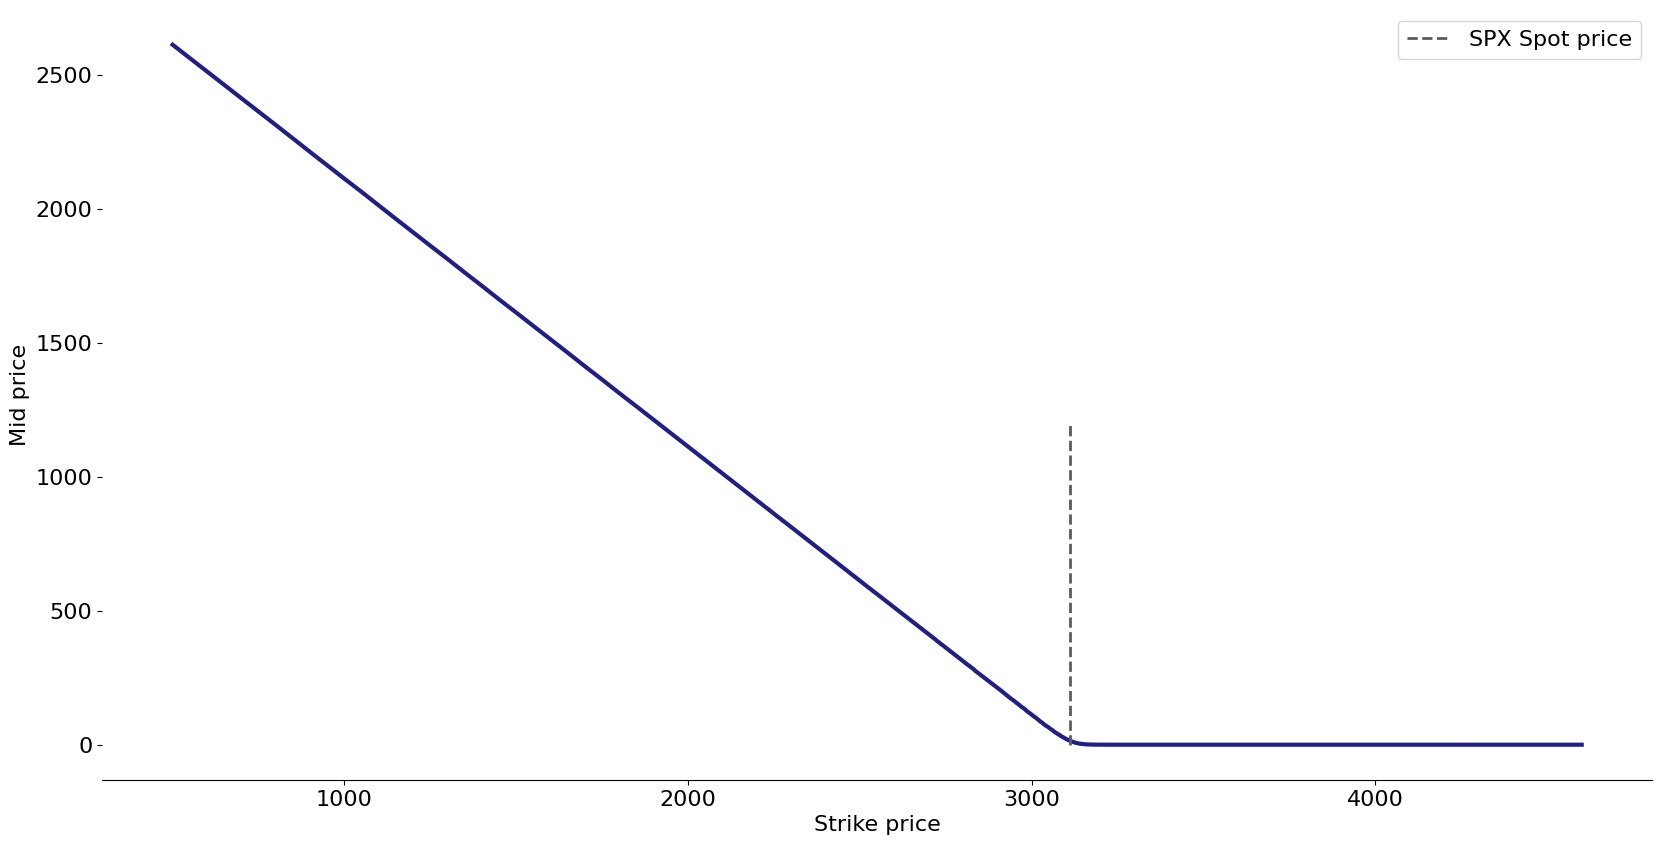

In [32]:
fig, ax = plt.subplots(figsize=(20,10))

# for df in spx_1dte_dfs:
    # ax.plot(df['strike'], df['call_mid'], alpha=.1)

df = spx_1dte_dfs[30]
ax.plot(df['strike'], df['call_mid'], color="#1F1F84", linewidth=3)
ax.vlines(df['underlying_last'].mean(), ymin=0, ymax=1200, color="#5C5C5C", linestyle="--", linewidth=2, label="SPX Spot price")

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel("Strike price")
ax.set_ylabel("Mid price");
ax.legend()


In order to apply the formula that we want, we need to interpolate this to a smooth function.
Interpolating on prices directly is dangerous as it can lead to spurious arbitrage opportunities.
It makes more sense to convert these prices to IV using Black-Scholes, interpolate on IV, and then convert back.
(Note that this data does come with an implied volatility included, but I'll calculate my own so that I know exactly where it comes from.)


(TODO: I still don't quite understand why this is better.)

/tmp/ipykernel_1617571/1281975476.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tte_years'] = df['tte_unix']/(60*60*24*365)
/tmp/ipykernel_1617571/1281975476.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['implied_volatility'] = df.apply(


,underlying_last,expire_unix,quote_unix,quote_time,strike,call_iv,call_bid,call_ask,call_last,put_iv,put_bid,put_ask,put_last,dte,tte_unix,call_mid,put_mid,tte_years,implied_volatility
24468,3112.3,1591387200,1591300800,2020-06-04 16:00,500.0,NaN,2610.39,2612.30,0.0,6.891470,0.00,0.06,0.00,1.0,86400,2611.345,0.030,0.00274,NaN
24469,3112.3,1591387200,1591300800,2020-06-04 16:00,600.0,NaN,2510.40,2512.29,0.0,6.204390,0.00,0.06,0.00,1.0,86400,2511.345,0.030,0.00274,NaN
24470,3112.3,1591387200,1591300800,2020-06-04 16:00,700.0,NaN,2408.60,2414.90,0.0,5.629280,0.00,0.05,0.10,1.0,86400,2411.750,0.025,0.00274,NaN
24471,3112.3,1591387200,1591300800,2020-06-04 16:00,800.0,NaN,2311.20,2313.01,0.0,5.139440,0.00,0.05,0.05,1.0,86400,2312.105,0.025,0.00274,NaN
24472,3112.3,1591387200,1591300800,2020-06-04 16:00,900.0,NaN,2210.30,2212.30,0.0,4.697680,0.00,0.05,0.15,1.0,86400,2211.300,0.025,0.00274,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24731,3112.3,1591387200,1591300800,2020-06-04 16:00,4200.0,1.18433,0.00,0.06,0.0,2.367080,1086.99,1088.80,0.00,1.0,86400,0.030,1087.895,0.00274,1.694145
24732,3112.3,1591387200,1591300800,2020-06-04 16:00,4300.0,1.27008,0.00,0.05,0.0,2.605650,1187.70,1189.61,1494.80,1.0,86400,0.025,1188.655,0.00274,1.793036
24733,3112.3,1591387200,1591300800,2020-06-04 16:00,4400.0,1.35198,0.00,0.05,0.0,2.800240,1286.99,1288.70,0.00,1.0,86400,0.025,1287.845,0.00274,1.910049
24734,3112.3,1591387200,1591300800,2020-06-04 16:00,4500.0,1.43294,0.00,0.04,0.0,3.032540,1385.30,1391.60,0.00,1.0,86400,0.020,1388.450,0.00274,1.993879


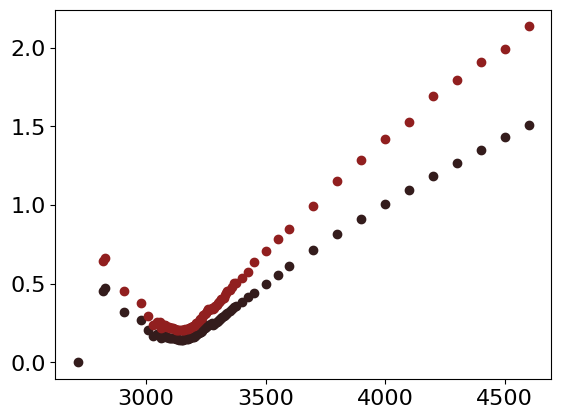

In [33]:
from black_scholes import *

# add a column for the time to expiry in years
df['tte_years'] = df['tte_unix']/(60*60*24*365)

df['implied_volatility'] = df.apply(
    lambda row: implied_volatility_call(
        market_price=row['call_mid'],
        S0 = row['underlying_last'],
        K=row['strike'],
        t=row['tte_years'],
        r=0.0
    ),
    axis=1
)

# ys = np.arange(0, df['call_iv'].max(), 1)
# labels = ys

# plt.yticks(ys, labels)


plt.scatter(df['strike'], df['call_iv'], color="#341C1C")
# plt.plot(df['strike'], df['implied_volatility'], color="#8A5A5A")
plt.scatter(df['strike'], df['implied_volatility'], color="#911F1F")

display(df)

# # plt.plot(one_m_calls['strike'], one_m_calls['implied_volatility'], label='Implied Volatility (custom)')


# x = one_m_calls['strike']
# y = one_m_calls['implied_volatility']

# # Fit smoothing spline
# # s is the smoothing factor
# one_m_calls_iv_smoothed = UnivariateSpline(x, y, s=0.005)




# strikes_fine = np.linspace(x.min(), x.max(), 1000)
# iv_fine = one_m_calls_iv_smoothed(strikes_fine)

# plt.scatter(x, y, s=10, label='IVs')
# plt.plot(strikes_fine, iv_fine, 'r', label="Cubic fit", lw=2, alpha=0.5)
# plt.legend()
# plt.show()




# mean_strike = one_m_calls['spot_price'].mean()
# mean_tte = one_m_calls['time_to_expiration'].mean()

# bs_fine = np.zeros(1000)

# for i in range(1000):
#     bs_fine[i] = bs_call(S0 = mean_strike,
#                          K=strikes_fine[i],
#                         sigma=iv_fine[i],
#                         t=mean_tte,
#                         r=0.0
#     )


# # now convert back to prices using Black-Scholes
# # to keep it smooth, we need to use a single value for the spot price
# # I hope that isn't too weird
# # I'll use the average
# # visually they look basically the same if I use a different price nearby
# # so I hope it's okay
# # TODO: think about this
# one_m_calls['smoothed_price'] = one_m_calls.apply(
#     lambda row: bs_call(
#         # S0 = row['spot_price'],
#         S0 = one_m_calls['spot_price'].mean(),
#         K=row['strike'],
#         sigma=one_m_calls_iv_smoothed(row['strike']),
#         t=row['time_to_expiration'],
#         r=0.0
#     ),
#     axis=1
# )


# plt.plot(one_m_calls['strike'], one_m_calls['smoothed_price'], alpha=.5)
# plt.plot(x_fine, bs_fine)
# # plt.plot(one_m_calls['strike'], one_m_calls['lastPrice'], alpha=.5)
# plt.show()


Now we need to do a little numeric differentiation to apply the Breeden-Litzenberger formula, which says that
$$f(K) = e^{rt} \frac{\partial^2 C}{\partial K^2}$$


### The Breeden-Litzenberger Formula
Recall that the fair value of a call option with time $\tau$ until expiry is the present value of the expected payoff.
If $f$ denotes the PDF of the stock prices $S_T$ of some stock $S$ at time $T$, this is
$$
\begin{align*}
C(K, \tau) &= e^{-rt} \mathbb E(\max\{S_T - K, 0\}) \\
&= e^{-rt} \int_0^\infty \max\{S_T - K, 0\} f(S_T) \, d S_T \\
&= e^{-rt} \int_K^\infty (x - K) f(x) \, dx.
\end{align*}
$$
To derive the Breeden-Litzenberger formula, we just need to invert this to find $f$ as a function of $C$.
Taking the partial derivative with respect to $K$ gives
$$
\begin{align*}
\frac{\partial C}{\partial K} &= - e^{-rt} \int_{K}^\infty f(x) \, dx \\
&= e^{-rt} \left( \int_{-\infty}^K f(x) \, dx - 1 \right),
\end{align*}
$$
where in the second step we use the fact that $\int_{\R} f(x) \, dx = 1$.
But now we can find $f$ by taking one more derivative.
Doing this and rearranging, we see that
$$f(K) = e^{rt} \frac{\partial^2 C}{\partial K^2}.$$

In [18]:

# f = np.gradient(bs_fine, strikes_fine)
# f_2 = np.gradient(f, strikes_fine)

# fig, ax1 = plt.subplots()

# ax1.plot(x_fine, bs_fine)
# ax1.set_xlabel('Strike')
# ax1.set_ylabel('Price PDF (smoothed)', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# ax2 = ax1.twinx()
# ax2.plot(strikes_fine, f_2, color='tab:red', label='pdf')
# ax2.set_ylabel('f(K)', color='tab:red')
# ax2.tick_params(axis='y', labelcolor='tab:red')


In [19]:
SIZE_DEFAULT = 16

plt.rcParams["xtick.labelsize"] = SIZE_DEFAULT


So we see what the market thinks the price of SPY is likely to be in one month.
We also need to do this analysis for the puts, and for the calls and puts with 2-month expiries.

# References and further reading

[Estimating the real-world density from the option-implied risk-neutral density, a paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2093397)

[A blog post about market-implied probabilities](https://blog.thinknewfound.com/2017/11/market-implied-probabilities-useful/)

In [20]:
SIZE_DEFAULT = 16

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = SIZE_DEFAULT